# EPID 717: Inverse Probability of Treatment Weighting
Code corresponding to the first-author publication example from lecture

Created by Paul Zivich (2024/10/15), modified by Valerie Lucas (2024/10/27)

### Homework 7
Inverse Probability of Treatment Weighting removes association between covariate and exposure in observational data.

In [1]:
# Ensure that saving source updates functions accessible in analysis.
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
import source.data_utils as utils
import numpy as np                                        # For array management and some functions
import pandas as pd                                       # For data management
import statsmodels.api as sm                              # For statistical models (logit, KM)
import statsmodels.formula.api as smf                     # For Wilkinson-style formulas
from statsmodels.stats.weightstats import DescrStatsW     # For calculating SMD easily
import matplotlib.pyplot as plt                           # For plotting

import scipy as sp                           # Scipy for root-finding and derivs
import delicatessen as deli                  # Delicatessen for M-estimators

# Loading Specific functions from prior libraries
from scipy.optimize import minimize, approx_fprime, newton
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression
from delicatessen.utilities import inverse_logit

DATA_DIRECTORY="../data"
DATA_FILE_PATH=f"{DATA_DIRECTORY}/rotterdam_clean.csv"
rotterdam = pd.read_csv(DATA_FILE_PATH)
rotterdam.info()

rotterdam1 = rotterdam.loc[rotterdam['hormon'] == 1].copy()                 # People who did not take hormone therapy
rotterdam0 = rotterdam.loc[rotterdam['hormon'] == 0].copy()                 # People who did not take hormone therapy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pid         1208 non-null   int64  
 1   time        1208 non-null   float64
 2   delta       1208 non-null   int64  
 3   hormon      1208 non-null   int64  
 4   age         1208 non-null   int64  
 5   meno        1208 non-null   int64  
 6   tumor_size  1208 non-null   float64
 7   nodes       1208 non-null   int64  
 8   node_cat    1208 non-null   float64
 9   chemo       1208 non-null   int64  
 10  grade       1208 non-null   int64  
 11  er          1208 non-null   int64  
 12  pgr         1208 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 122.8 KB


1. To begin, estimate the 3-year risk difference comparing hormone therapy to no hormone therapy using a crude stratified Kaplan-Meier. What is the 3-year risk difference? What is the 3-year risk ratio? What do these results indicate? OPTIONAL: Plot the risk functions.

The hormone therapy is associated with reduced risk of death or cancer recurrence. If all statistical and causal assumptions are met, the hormone therapy reduced risk of death or cancer recurrence. The crude risk ratio is 0.801751, and the crude risk difference is -0.087808.


Risk difference:
1093.000054   -0.087808
Name: rd, dtype: float64

Risk Ratio:
1093.000054    0.801751
Name: rr, dtype: float64


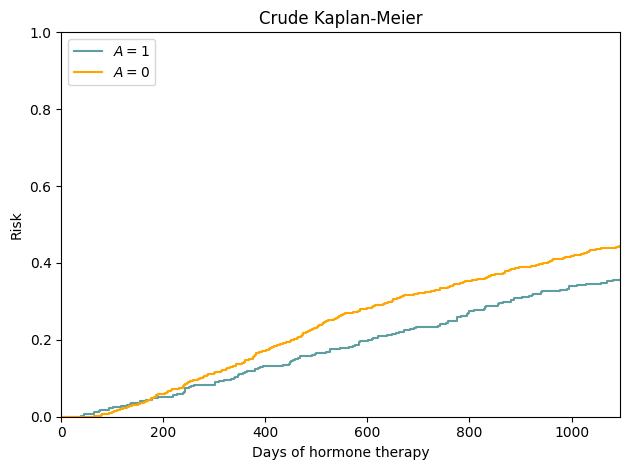

In [3]:

# Estimate risk for people with and without the hormone treatment using function
risk_n1 = utils.zKM_estimate(data = rotterdam1, time = 'time', delta = 'delta')
risk_n0 = utils.zKM_estimate(data = rotterdam0, time = 'time', delta = 'delta')


# Putting results together to compute the risk difference
risk_n = pd.merge(risk_n1, risk_n0, how='outer',                # Outer merge risk data on time
                   left_index=True, right_index=True)           # ... on time (the index of risk_n)
tzero = pd.DataFrame([[0., 0.], ],                              # Creating row of zeroes for t=0
                     columns=['Surv prob_x', 'Surv prob_y'])
risk_n = pd.concat([tzero, risk_n])                             # Adding zero row to risk data
risk_n = risk_n.ffill()                                         # Forward-filling all missing risks on aligned times
risk_n['rd'] = risk_n['Surv prob_x'] - risk_n['Surv prob_y']    # Computing the risk difference across columns
risk_n['rr'] = risk_n['Surv prob_x'] / risk_n['Surv prob_y']    # Computing the risk ratio across columns

# Return risk difference and risk ratio
print(f"Risk difference:\n{risk_n['rd'].tail(1)}\n\nRisk Ratio:\n{risk_n['rr'].tail(1)}")

# Plot unadjusted risk functions
plt.step([0., ] + list(risk_n1.index) + [1095., ], [0., ] + list(risk_n1) + [list(risk_n1)[-1], ],
         where='post', color='cadetblue', label=r'$A=1$')
plt.step([0., ] + list(risk_n0.index) + [1095., ], [0., ] + list(risk_n0) + [list(risk_n0)[-1], ],
         where='post', color='orange', label=r'$A=0$')
plt.ylim([0., 1.0])
plt.ylabel("Risk")
plt.xlim([0, 1095])
plt.xlabel("Days of hormone therapy")
plt.title("Crude Kaplan-Meier")
plt.legend(loc=2)
plt.tight_layout()
plt.show()

2. To estimate the 3-year risk difference comparing hormone therapy to no hormone therapy using an inverse prob- ability of treatment weighted Kaplan-Meier, we first need to compute the weights. Follow the algorithm described in lecture.

For PID = 10, the predicted probability of treatment is: 0.16080. The corresponding inverse probability of treatment weight is 1.191610.

In [4]:
# IPTW Kaplan-Meier

# Fit a nuisance model for propensity scores via logistic regression
fam = sm.families.Binomial()                                     # Specify LINK=logit, DIST=binomial
fm = smf.glm("hormon ~ age + chemo + meno + C(node_cat) + C(tumor_size) + C(grade) + pgr + er", rotterdam, family=fam).fit()    # GLM with Wilkinson-style formula
print(fm.summary())                                              # Displaying regression coefficient results

# Get predicted probabilities of treatment
rotterdam['pi_a'] = fm.predict(rotterdam)                                        # Predicted probabilities of seminar attendance


# Calculate IPTW
rotterdam['iptw'] = rotterdam['hormon'] / rotterdam['pi_a'] + (1 - rotterdam['hormon']) / (1-rotterdam['pi_a'])  # Lecture equation

rotterdam.head(1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 hormon   No. Observations:                 1208
Model:                            GLM   Df Residuals:                     1197
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -637.23
Date:                Thu, 31 Oct 2024   Deviance:                       1274.5
Time:                        11:17:48   Pearson chi2:                 1.29e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1053
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.9393 

,pid,time,delta,hormon,age,meno,tumor_size,nodes,node_cat,chemo,grade,er,pgr,pi_a,iptw
0,10,1095.75,0,0,52,0,1.0,5,2.0,0,3,976,316,0.1608,1.19161


3. Before applying our inverse probability of treatment weights, we should check whether they are reasonable. To do this, we will perform a few diagnostic procedures.

The minimum propensity score is 0.019334, and the maximum propensity score is 0.474789. The minimum weight is 1.019716 and the maximum weight is 41.949818. Not sure if the min/max are reasonable given 1208 observations. The mean weight is 2.065131, which is pretty close to 2. The plot below suggests a possible positivity violation for lower propensity of treatment scores.

count    1208.000000
mean        0.269868
std         0.136505
min         0.019334
25%         0.129725
50%         0.310028
75%         0.383534
max         0.474789
Name: pi_a, dtype: float64
count    1208.000000
mean        2.065131
std         2.829188
min         1.019716
25%         1.195126
50%         1.542510
75%         2.274448
max        41.949818
Name: iptw, dtype: float64


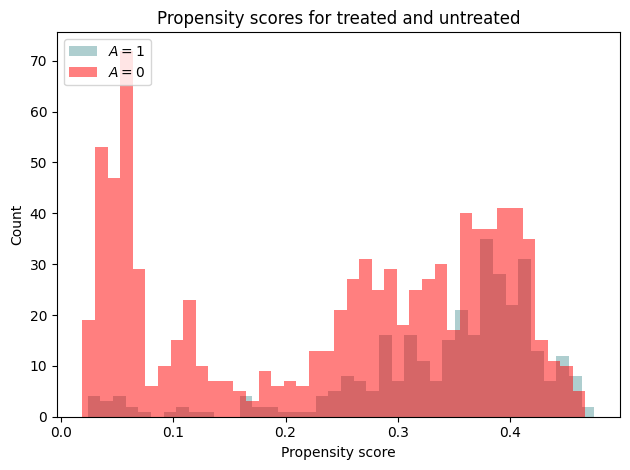

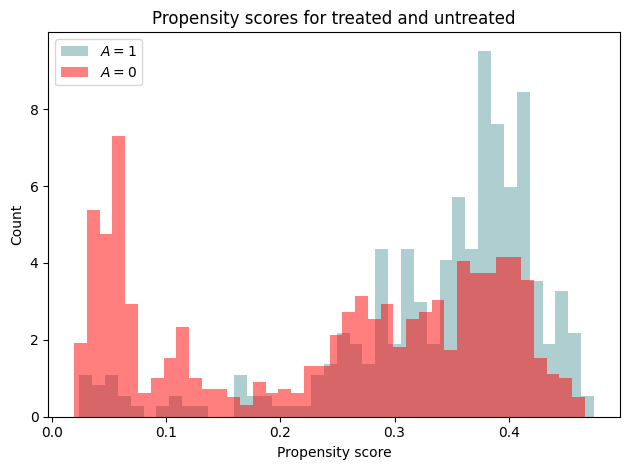

In [5]:
print(rotterdam['pi_a'].describe())
print(rotterdam['iptw'].describe())

plt.hist(rotterdam.mask(rotterdam['hormon'] == 0)['pi_a'],
        color='cadetblue', label=r'$A=1$', alpha = 0.5, bins = 40)
plt.hist(rotterdam.mask(rotterdam['hormon'] == 1)['pi_a'],
        color='red', label=r'$A=0$', alpha = 0.5, bins = 40)
plt.ylabel("Count")
plt.xlabel("Propensity score")
plt.title("Propensity scores for treated and untreated")
plt.legend(loc=2)
plt.tight_layout()
plt.show()


plt.hist(rotterdam.mask(rotterdam['hormon'] == 0)['pi_a'],
        color='cadetblue', label=r'$A=1$', alpha = 0.5, bins = 40, density = True)
plt.hist(rotterdam.mask(rotterdam['hormon'] == 1)['pi_a'],
        color='red', label=r'$A=0$', alpha = 0.5, bins = 40, density = True)
plt.ylabel("Count")
plt.xlabel("Propensity score")
plt.title("Propensity scores for treated and untreated")
plt.legend(loc=2)
plt.tight_layout()
plt.show()

4. Estimate the 3-year risk difference comparing hormone therapy to no hormone therapy using a IPTW stratified Kaplan-Meier (or Nelson-Aalen if using SAS). NOTE: recall that SAS uses Nelson-Aalen, so results may differ slightly across software.

The hormone therapy is associated with reduced risk of death or cancer recurrence. If all statistical and causal assumptions are met, the hormone therapy reduced risk of death or cancer recurrence. The adjusted risk ratio is 0.631326, and the adjusted risk difference is -0.171313.


In [6]:
rotterdam1 = rotterdam.loc[rotterdam['hormon'] == 1].copy()                 # People who did not take hormone therapy
rotterdam0 = rotterdam.loc[rotterdam['hormon'] == 0].copy()

risk_w1 = utils.zKM_estimate(data = rotterdam1, time = 'time', delta = 'delta', weights = rotterdam1['iptw'])
risk_w0 = utils.zKM_estimate(data = rotterdam0, time = 'time', delta = 'delta', weights = rotterdam0['iptw'])

risk_w = pd.merge(risk_w1, risk_w0, how='outer',                # Outer merge risk data on time
                   left_index=True, right_index=True)           # ... on time (the index of risk_w)
tzero_w = pd.DataFrame([[0., 0.], ],                              # Creating row of zeroes for t=0
                     columns=['Surv prob_x', 'Surv prob_y'])
risk_w = pd.concat([tzero_w, risk_w])                             # Adding zero row to risk data
risk_w = risk_w.ffill()                                         # Forward-filling all missing risks on aligned times
risk_w['rd'] = risk_w['Surv prob_x'] - risk_w['Surv prob_y']    # Computing the risk difference across columns
risk_w['rr'] = risk_w['Surv prob_x'] / risk_w['Surv prob_y']    # Computing the risk ratio across columns

print(f"Risk difference:\n{risk_w['rd'].tail(1)}\n\nRisk Ratio:\n{risk_w['rr'].tail(1)}")

Risk difference:
1093.000054   -0.171313
Name: rd, dtype: float64

Risk Ratio:
1093.000054    0.631326
Name: rr, dtype: float64


5. Plot the risk functions from the inverse probability weighted Kaplan-Meier (or Nelson-Aalen). What is the 3-year risk difference? What does this risk difference indicate?

If all statistical and causal assumptions are met, the hormone therapy reduced risk of death or cancer recurrence by 17.1 percentage points.

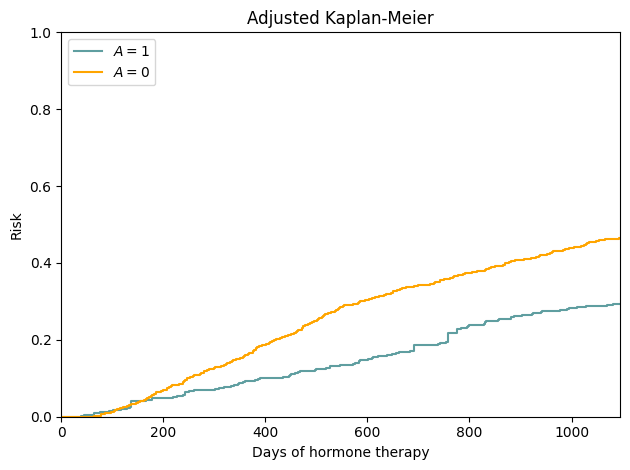

In [7]:
plt.step([0., ] + list(risk_w1.index) + [1095., ], [0., ] + list(risk_w1) + [list(risk_w1)[-1], ],
         where='post', color='cadetblue', label=r'$A=1$')
plt.step([0., ] + list(risk_w0.index) + [1095., ], [0., ] + list(risk_w0) + [list(risk_w0)[-1], ],
         where='post', color='orange', label=r'$A=0$')
plt.ylim([0., 1.0])
plt.ylabel("Risk")
plt.xlim([0, 1095])
plt.xlabel("Days of hormone therapy")
plt.title("Adjusted Kaplan-Meier")
plt.legend(loc=2)
plt.tight_layout()
plt.show()

6. Compare the 3-year risk differences and risk ratios from the crude Kaplan-Meier and the IPTW Kaplan-Meier. What does the difference between these results suggest?

The difference between the unweighted and weighted risk differences suggests that characteristics increasing the likelihood of treatment made death or recurrence more likely. The unweighted risk difference underestimates the effect of the treatment -- possibly because sicker people are more likely to be given the treatment. Crude RR is biased upwards towards the null. Crude RD is biased upwards towards the null. 

7. What are the identification assumptions relied on to interpret the IPTW Kaplan-Meier as a causal effect? What are some challenges to these assumptions?

Some assumptions are: typical statistical assumptions (independent and identically distributed data, random sample of population), uninformative censoring, model functional form is correct, causal consistency (treatment is the same as if it had been pre-assigned), and conditional exchangeability with positivity (adjusting for known and measured covariates, the treated and untreated are the same prior to treatment with enough people to estimate). I doubt that exchangeability with positivity applies here.

8. OPTIONAL: Estimate the variance for the 3-year risk difference using the bootstrap. Here, use the SD implementation with 200 repetitions. What are the 95% confidence intervals? Provide an interpretation of these results.



In [8]:


rotterdam_x = rotterdam

rotterdam_x['node_cat'] = rotterdam_x['node_cat'].astype(str)
rotterdam_x['tumor_size'] = rotterdam_x['tumor_size'].astype(str)
rotterdam_x['grade'] = rotterdam_x['grade'].astype(str)

rotterdam_x['intercept'] = 1

rotterdam_x = pd.get_dummies(rotterdam_x)

rotterdam_x.info()

X = np.asarray(rotterdam_x[['intercept', 'age', 'chemo', 'meno', 'tumor_size_0.0', 'tumor_size_1.0', 'node_cat_0.0', 'node_cat_1.0', 'grade_2', 'pgr', 'er']])   # Design matrix for regression
y = np.asarray(rotterdam_x['delta'])                       # Outcome in regression

n = rotterdam_x.shape[0]

def psi(theta):
    # Dividing parameters into corresponding parts and labels from slides
    alpha = theta[0:2]                    # Logistic model coefficients
    mu0, mu1 = theta[2], theta[3]         # Causal risks
    delta1 = theta[4]                     # Causal contrast

    # Using built-in regression model functionality from delicatessen
    ee_logit = ee_regression(theta=alpha,             # Regression model
                             y=rotterdam_x['hormon'],                # ... for exposure
                             X=rotterdam_x[['intercept', 'age', 'chemo', 'meno', 'tumor_size_0.0', 'tumor_size_1.0', 'node_cat_0.0', 'node_cat_1.0', 'grade_2', 'pgr', 'er']], # ... given confounders
                             model='logistic')        # ... logistic model

    # Transforming logistic model coefficients into causal parameters
    pscore = inverse_logit(np.dot(rotterdam_x['intercept', 'age', 'chemo', 'meno', 'tumor_size_0.0', 'tumor_size_1.0', 'node_cat_0.0', 'node_cat_1.0', 'grade_2', 'pgr', 'er'], alpha))  # Propensity score
    wt = rotterdam_x['hormon']/pscore + (1-rotterdam_x['hormon'])/(1-pscore)                    # Corresponding weights

    # Estimating function for causal risk under a=1
    ee_r1 = rotterdam_x['hormon']*rotterdam_x['delta']*wt - mu1                   # Weighted conditional mean
    
    # Estimating function for causal risk under a=0
    ee_r0 = (1-rotterdam_x['hormon'])*rotterdam_x['delta']*wt - mu0               # Weighted conditional mean
    
    # Estimating function for causal risk difference
    ee_rd = np.ones(rotterdam_x.shape[0])*((mu1 - mu0) - delta1)

    # Returning stacked estimating functions in order of parameters
    return np.vstack([ee_logit,   # EF of logistic model
                      ee_r0,      # EF of causal risk a=0
                      ee_r1,      # EF of causal risk a=1
                      ee_rd])     # EF of causal contrast



# Applying M-estimator
mestr = MEstimator(psi,                       # For given EF
                   init=[0, 0, 0.5, 0.5, 0])  # ... at generic starting values
mestr.estimate()                              # Estimation procedure


# Formatting results into a nice table
result = pd.DataFrame()
result['Param'] = ['alpha_0', 'alpha_1', 'mu_0', 'mu_1', 'delta']
result['Coef'] = mestr.theta
ci = mestr.confidence_intervals()
result['LCL'] = ci[:, 0]
result['UCL'] = ci[:, 1]
print("IPW")
result.round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             1208 non-null   int64  
 1   time            1208 non-null   float64
 2   delta           1208 non-null   int64  
 3   hormon          1208 non-null   int64  
 4   age             1208 non-null   int64  
 5   meno            1208 non-null   int64  
 6   nodes           1208 non-null   int64  
 7   chemo           1208 non-null   int64  
 8   er              1208 non-null   int64  
 9   pgr             1208 non-null   int64  
 10  pi_a            1208 non-null   float64
 11  iptw            1208 non-null   float64
 12  intercept       1208 non-null   int64  
 13  tumor_size_0.0  1208 non-null   bool   
 14  tumor_size_1.0  1208 non-null   bool   
 15  tumor_size_2.0  1208 non-null   bool   
 16  node_cat_0.0    1208 non-null   bool   
 17  node_cat_1.0    1208 non-null   b

ValueError: shapes (1208,11) and (2,1) not aligned: 11 (dim 1) != 2 (dim 0)

In [ ]:
rotterdam_y = rotterdam

rotterdam_y['node_cat'] = rotterdam_y['node_cat'].astype(str)
rotterdam_y['tumor_size'] = rotterdam_y['tumor_size'].astype(str)
rotterdam_y['grade'] = rotterdam_y['grade'].astype(str)

rotterdam_y['intercept'] = 1

rotterdam_y = pd.get_dummies(rotterdam_y)

rotterdam_y.info()

X = np.asarray(rotterdam_y[['intercept', 'age', 'chemo', 'meno', 'tumor_size_0.0', 'tumor_size_1.0', 'node_cat_0.0', 'node_cat_1.0', 'grade_2', 'pgr', 'er']])   # Design matrix for regression
y = np.asarray(rotterdam_y['delta'])                       # Outcome in regression



def ee_logistic(theta): 
    # Estimating equation for the logistic model
    beta = np.asarray(theta)[:, None]    # Reshaping parameter array for dot product

    # Looping through each observation
    est_vals = []                        # Empty list for storage
    for i in range(n):                   # For each observation in the data
        logodds = np.dot(X[i], beta)     # ... Log-odds of Y given design
        prob_y = inverse_logit(logodds)  # ... Predicted probability of Y
        v_i = (y[i] - prob_y)*X[i]       # ... Estimating function for O_i
        est_vals.append(v_i)             # ... Storing contribution
    
    # Return estimating functions stacked together
    return np.asarray(est_vals).T


def sum_ee(theta):
    # Function to sum the previous estimating equation over all i's
    stacked_equations = np.asarray(ee_logistic(theta))  # Returning stacked equation
    vals = ()                                           # Create empty tuple
    for i in stacked_equations:                         # Go through each individual theta
        vals += (np.sum(i), )                           # Add the theta sum to the tuple of thetas

    # Return the calculated values of theta
    return vals


def solve_m_estimator(stacked_equations, init):
    # Wrapper function for SciPy root-finding 
    psi = newton(stacked_equations,    # stacked equations to solve (written as sums)
                 x0=np.asarray(init),  # initial values for solver
                 maxiter=2000,         # Increasing iterations
                 disp=True)            # Raise RuntimeError if doesn't converge
    return psi


# Solving the estimating equations for beta
theta = solve_m_estimator(stacked_equations=sum_ee,
                          init=[0, 0, 0]
                          )
print(theta)


9. CHALLENGE: There might be some issues with our analysis as identified in Q3 and Q7. How could you improve these analyses? Try implementing these improvements yourself. How does your answer change?

I trimmed the dataset to only include those with a propensity of treatment score greater than 0.25. The adjusted risk ratio among those with a propensity score greater than 0.25 is 0.669135, and the adjusted risk difference among those with a propensity score greater than 0.25 is -0.178208


Risk difference:
1093.000054   -0.178208
Name: rd, dtype: float64

Risk Ratio:
1093.000054    0.669135
Name: rr, dtype: float64


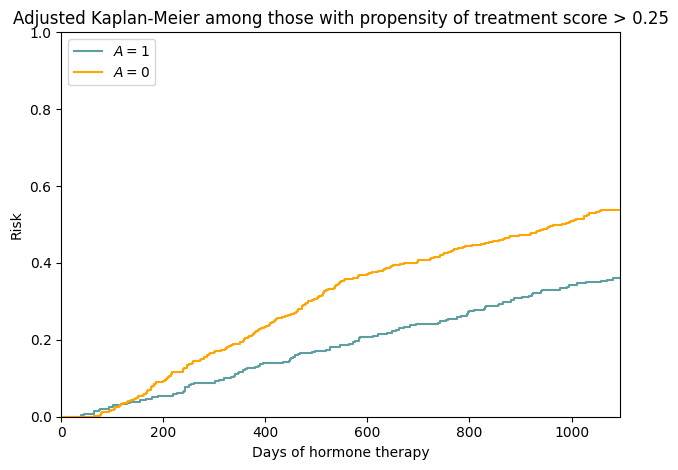

In [46]:

rotterdam_t = rotterdam.loc[rotterdam['pi_a'] > 0.25].copy()

rotterdam_t1 = rotterdam_t.loc[rotterdam_t['hormon'] == 1].copy()                 # People who did not take hormone therapy
rotterdam_t0 = rotterdam_t.loc[rotterdam_t['hormon'] == 0].copy()                 # People who did not take hormone therapy

risk_t1 = utils.zKM_estimate(data = rotterdam_t1, time = 'time', delta = 'delta', weights = rotterdam_t1['iptw'])
risk_t0 = utils.zKM_estimate(data = rotterdam_t0, time = 'time', delta = 'delta', weights = rotterdam_t0['iptw'])


# Putting results together to compute the risk difference
risk_t = pd.merge(risk_t1, risk_t0, how='outer',                # Outer merge risk data on time
                   left_index=True, right_index=True)           # ... on time (the index of risk_t)
tzero_t = pd.DataFrame([[0., 0.], ],                              # Creating row of zeroes for t=0
                     columns=['Surv prob_x', 'Surv prob_y'])
risk_t = pd.concat([tzero, risk_t])                             # Adding zero row to risk data
risk_t = risk_t.ffill()                                         # Forward-filling all missing risks on aligned times
risk_t['rd'] = risk_t['Surv prob_x'] - risk_t['Surv prob_y']    # Computing the risk difference across columns
risk_t['rr'] = risk_t['Surv prob_x'] / risk_t['Surv prob_y']    # Computing the risk ratio across columns




print(f"Risk difference:\n{risk_t['rd'].tail(1)}\n\nRisk Ratio:\n{risk_t['rr'].tail(1)}")



plt.step([0., ] + list(risk_t1.index) + [1095., ], [0., ] + list(risk_t1) + [list(risk_t1)[-1], ],
         where='post', color='cadetblue', label=r'$A=1$')
plt.step([0., ] + list(risk_t0.index) + [1095., ], [0., ] + list(risk_t0) + [list(risk_t0)[-1], ],
         where='post', color='orange', label=r'$A=0$')
plt.ylim([0., 1.0])
plt.ylabel("Risk")
plt.xlim([0, 1095])
plt.xlabel("Days of hormone therapy")
plt.title("Adjusted Kaplan-Meier among those with propensity of treatment score > 0.25")
plt.legend(loc=2)
plt.tight_layout()
plt.show()